In [2]:
import spacy
from spacy.tokens import DocBin
from spacy.training import Example
from pathlib import Path
import pandas as pd

# ---------- Config ----------
BASE_DIR = Path("/home/jesse/Projects/myprojs/Master_Thesis/Fengdi_Huang_Master_Thesis_Repo")
TEST_PATH = BASE_DIR / "Corpus/test/lv_lvtb-ud-test.spacy"

MODELS = [
    ("lv_spacy_cnn_1pct",  "CNN", 1),
    ("lv_spacy_cnn_5pct",  "CNN", 5),
    ("lv_spacy_cnn_20pct", "CNN", 20),
    ("lv_spacy_cnn_50pct", "CNN", 50),
    ("lv_spacy_cnn_100pct","CNN",100),
    ("lv_roberta_base_1pct",  "XLM-R-base", 1),
    ("lv_roberta_base_5pct",  "XLM-R-base", 5),
    ("lv_roberta_base_20pct", "XLM-R-base",20),
    ("lv_roberta_base_50pct", "XLM-R-base",50),
    ("lv_roberta_base_100pct","XLM-R-base",100),
    ("lv_roberta_large_1pct",  "XLM-R-large", 1),
    ("lv_roberta_large_5pct",  "XLM-R-large", 5),
    ("lv_roberta_large_20pct", "XLM-R-large",20),
    ("lv_roberta_large_50pct", "XLM-R-large",50),
    ("lv_roberta_large_100pct","XLM-R-large",100),
]

# ---------- Load test docs once ----------
test_docbin = DocBin().from_disk(TEST_PATH)

summary_rows = []
oov_rows = []

# ---------- Run loop ----------
for model_name, model_type, pct in MODELS:
    print(f"\n🔹 Evaluating {model_name} ...")
    nlp = spacy.load(model_name)
    train_path = BASE_DIR / f"Corpus/train/lv_lvtb-ud-train-{pct}pct.spacy"

    # === Build gold docs ===
    gold_docs = list(test_docbin.get_docs(nlp.vocab))
    preds = list(nlp.pipe((doc.text for doc in gold_docs), batch_size=32))
    examples = [Example(gold, pred) for gold, pred in zip(gold_docs, preds)]

    # === 1️⃣ Standard evaluation ===
    scores = nlp.evaluate(examples)
    summary_rows.append({
        "model": model_name,
        "framework": model_type,
        "data_pct": pct,
        "POS": scores.get("pos_acc"),
        "LAS": scores.get("dep_las"),
        "MorphF1": scores.get("morph_micro_f"),
        "Lemma": scores.get("lemma_acc"),
        "SentF": scores.get("sents_f"),
    })

    # === 2️⃣ OOV/IV evaluation ===
    train_vocab = set()
    train_docs = DocBin().from_disk(train_path)
    for doc in train_docs.get_docs(nlp.vocab):
        for token in doc:
            train_vocab.add(token.text)

    metrics = {k: {"iv_total":0,"iv_correct":0,"oov_total":0,"oov_correct":0}
               for k in ["POS","MORPH","LEMMA","UAS","LAS"]}

    for gold_doc, pred_doc in zip(gold_docs, preds):
        for g, p in zip(gold_doc, pred_doc):
            is_iv = g.text in train_vocab
            gold_morph, pred_morph = g.morph.to_dict(), p.morph.to_dict()
            if is_iv:
                metrics["POS"]["iv_total"] += 1
                if g.pos_ == p.pos_: metrics["POS"]["iv_correct"] += 1
            else:
                metrics["POS"]["oov_total"] += 1
                if g.pos_ == p.pos_: metrics["POS"]["oov_correct"] += 1
            # morph
            if is_iv:
                metrics["MORPH"]["iv_total"] += 1
                if gold_morph == pred_morph: metrics["MORPH"]["iv_correct"] += 1
            else:
                metrics["MORPH"]["oov_total"] += 1
                if gold_morph == pred_morph: metrics["MORPH"]["oov_correct"] += 1
            # lemma
            if is_iv:
                metrics["LEMMA"]["iv_total"] += 1
                if g.lemma_ == p.lemma_: metrics["LEMMA"]["iv_correct"] += 1
            else:
                metrics["LEMMA"]["oov_total"] += 1
                if g.lemma_ == p.lemma_: metrics["LEMMA"]["oov_correct"] += 1
            # parse
            if g.head:
                for key in ["UAS","LAS"]:
                    target_ok = g.head.i == p.head.i
                    if key == "LAS": target_ok = target_ok and (g.dep_ == p.dep_)
                    if is_iv:
                        metrics[key]["iv_total"] += 1
                        if target_ok: metrics[key]["iv_correct"] += 1
                    else:
                        metrics[key]["oov_total"] += 1
                        if target_ok: metrics[key]["oov_correct"] += 1

    for comp, m in metrics.items():
        iv_acc = m["iv_correct"]/m["iv_total"]*100 if m["iv_total"] else None
        oov_acc = m["oov_correct"]/m["oov_total"]*100 if m["oov_total"] else None
        oov_rows.append({
            "model": model_name, "framework": model_type, "data_pct": pct,
            "component": comp, "IV_acc": iv_acc, "OOV_acc": oov_acc
        })

# ---------- Save ----------
df_eval = pd.DataFrame(summary_rows)
df_eval.to_csv("./Summary_CSVs/evaluation_summary.csv", index=False)

df_oov = pd.DataFrame(oov_rows)
df_oov.to_csv("./Summary_CSVs/oov_iv_summary.csv", index=False)

print("\n✅ Saved evaluation_summary.csv and oov_iv_summary.csv")



🔹 Evaluating lv_spacy_cnn_1pct ...

🔹 Evaluating lv_spacy_cnn_5pct ...

🔹 Evaluating lv_spacy_cnn_20pct ...

🔹 Evaluating lv_spacy_cnn_50pct ...

🔹 Evaluating lv_spacy_cnn_100pct ...

🔹 Evaluating lv_roberta_base_1pct ...

🔹 Evaluating lv_roberta_base_5pct ...

🔹 Evaluating lv_roberta_base_20pct ...

🔹 Evaluating lv_roberta_base_50pct ...

🔹 Evaluating lv_roberta_base_100pct ...

🔹 Evaluating lv_roberta_large_1pct ...

🔹 Evaluating lv_roberta_large_5pct ...

🔹 Evaluating lv_roberta_large_20pct ...

🔹 Evaluating lv_roberta_large_50pct ...

🔹 Evaluating lv_roberta_large_100pct ...

✅ Saved evaluation_summary.csv and oov_iv_summary.csv


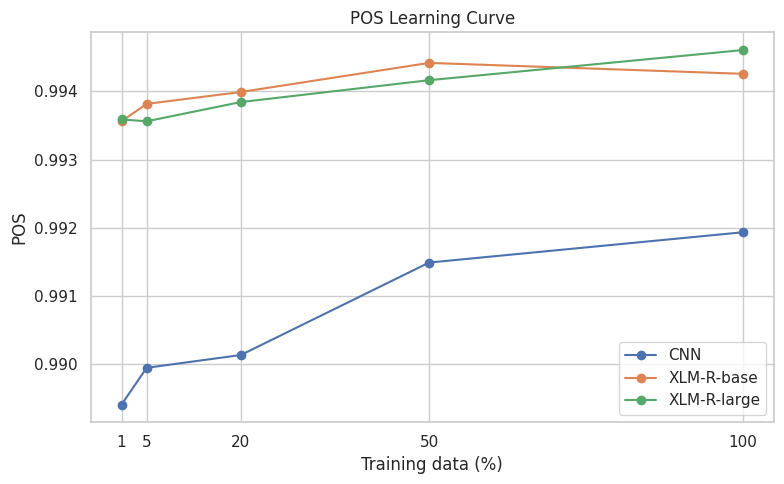

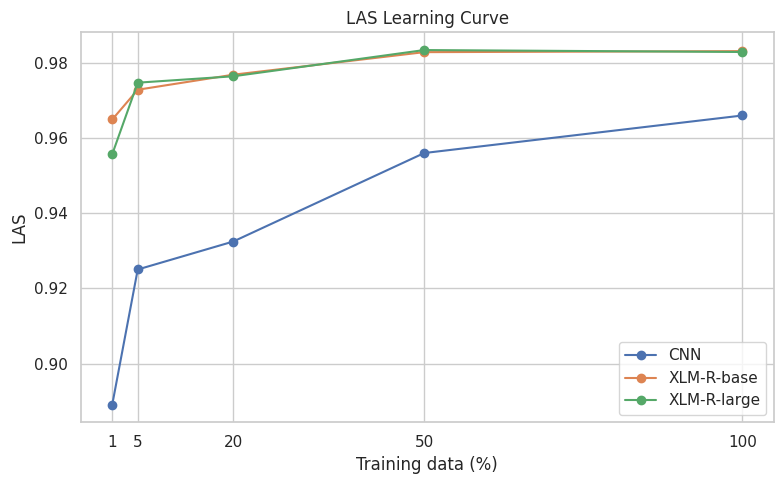

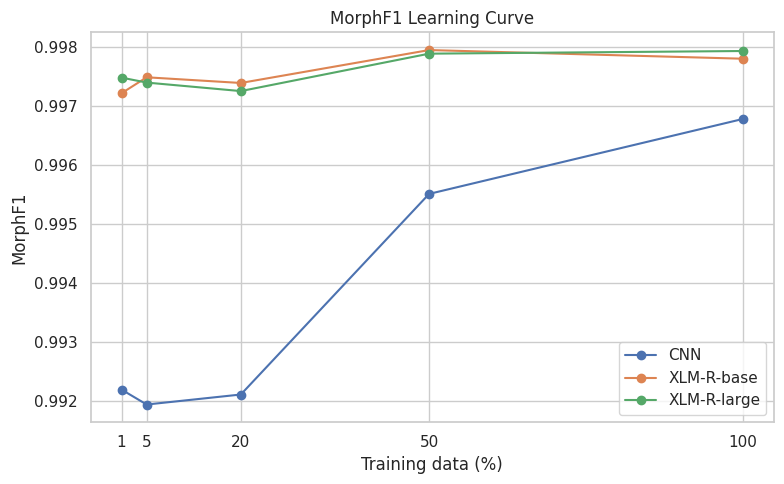

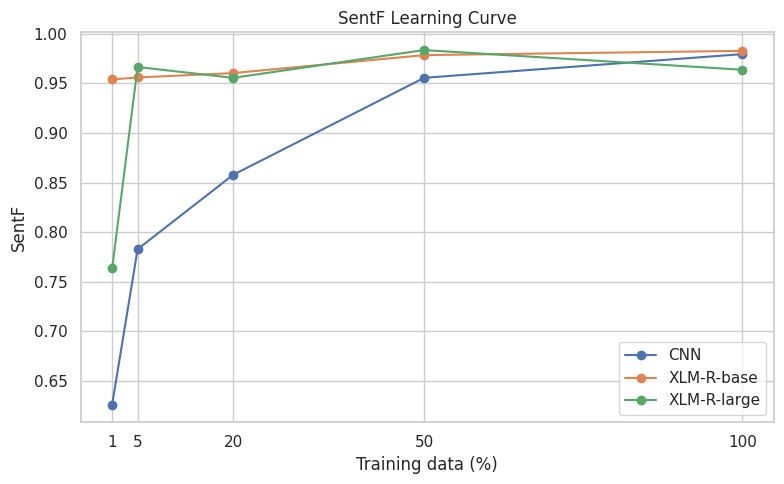

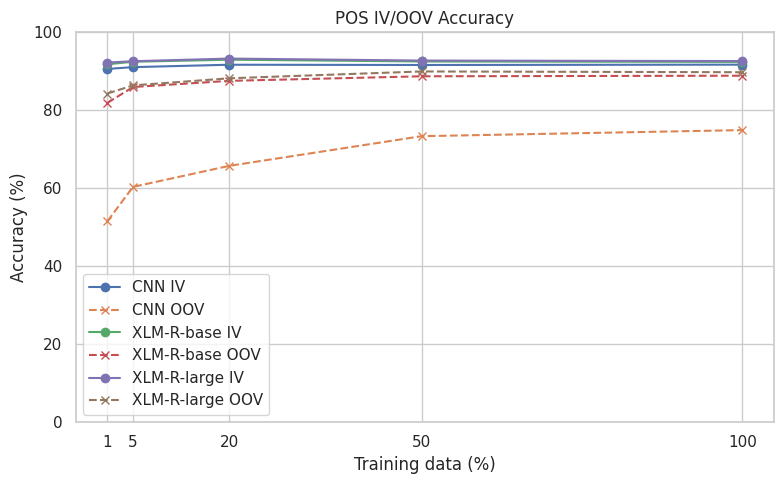

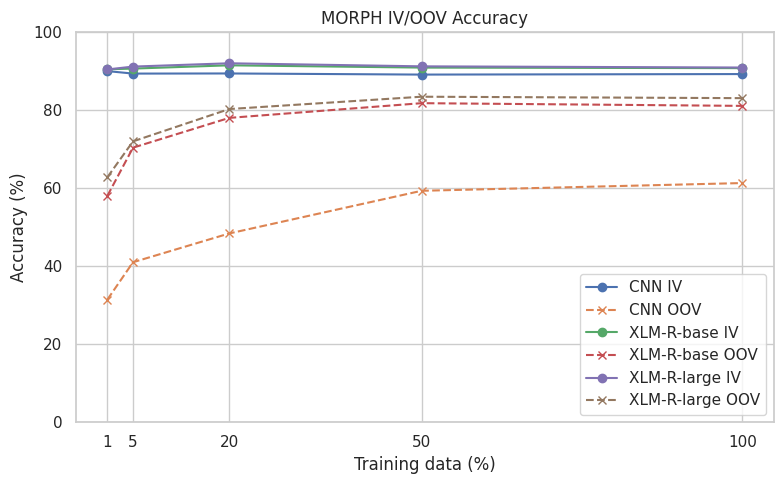

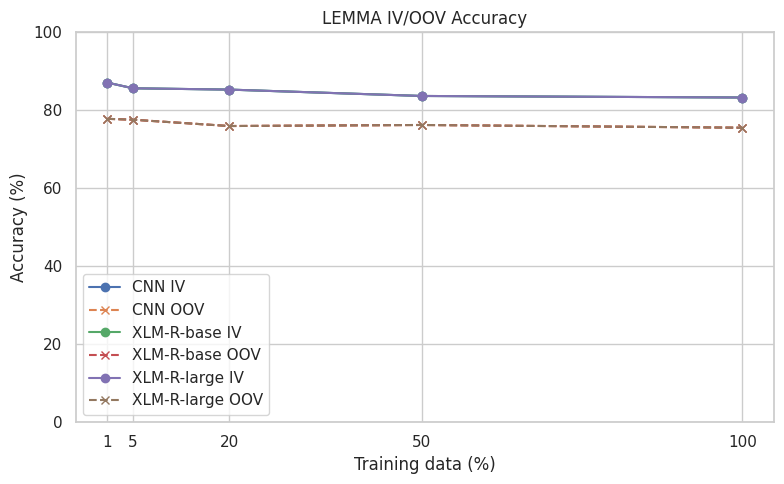

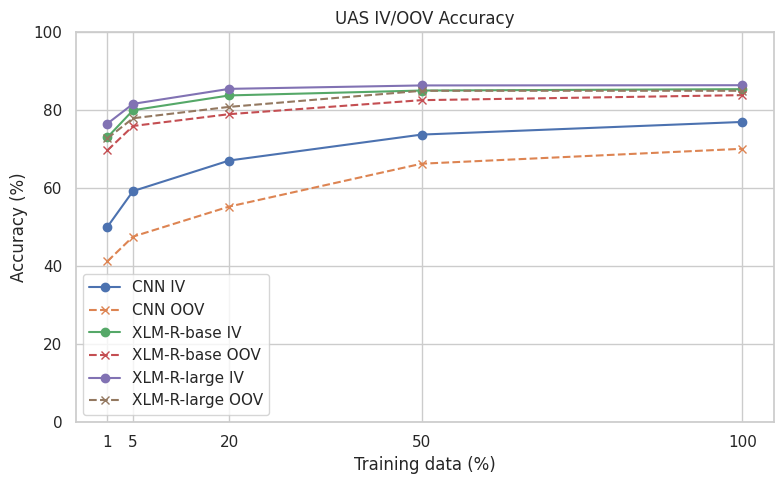

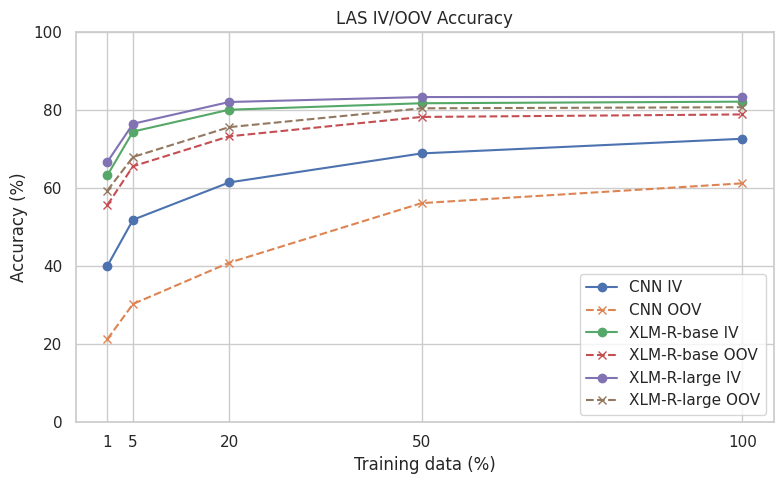

In [4]:
# === 可视化学习曲线和 OOV/IV ===
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# ---------- 1️⃣ Load CSVs ----------
df_eval = pd.read_csv("./Summary_CSVs/evaluation_summary.csv")
df_oov  = pd.read_csv("./Summary_CSVs/oov_iv_summary.csv")

# ---------- 2️⃣ 学习曲线 ----------

metrics = ["POS", "LAS", "MorphF1", "SentF"]  # 可以加上 Lemma, SentF
x_order = [1, 5, 20, 50, 100]

for metric in metrics:
    plt.figure(figsize=(8,5))
    for framework in df_eval["framework"].unique():
        sub = df_eval[df_eval["framework"] == framework].copy()
        # 保证顺序
        sub = sub.set_index("data_pct").reindex(x_order).reset_index()
        plt.plot(sub["data_pct"], sub[metric], marker="o", label=framework)
    plt.title(f"{metric} Learning Curve")
    plt.xlabel("Training data (%)")
    plt.ylabel(metric)
    plt.xticks(x_order)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---------- 3️⃣ OOV/IV 对比 ----------

components = df_oov["component"].unique()

for comp in components:
    plt.figure(figsize=(8,5))
    sub = df_oov[df_oov["component"] == comp]
    for framework in sub["framework"].unique():
        sub_fw = sub[sub["framework"] == framework]
        # IV accuracy
        plt.plot(sub_fw["data_pct"], sub_fw["IV_acc"], marker="o", linestyle="-", label=f"{framework} IV")
        # OOV accuracy
        plt.plot(sub_fw["data_pct"], sub_fw["OOV_acc"], marker="x", linestyle="--", label=f"{framework} OOV")
    plt.title(f"{comp} IV/OOV Accuracy")
    plt.xlabel("Training data (%)")
    plt.ylabel("Accuracy (%)")
    plt.xticks(x_order)
    plt.ylim(0, 100)
    plt.legend()
    plt.tight_layout()
    plt.show()
